In [20]:
# Imports
import re
from pathlib import Path
import pandas as pd
import numpy as np
import nibabel as nib
from scipy.ndimage import binary_dilation
from skimage.draw import line_nd
import pyvista as pv
import kimimaro
import networkx as nx
from sklearn.metrics import euclidean_distances
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="ticks", context="paper", palette="colorblind", font_scale=1.5)
save_dir = Path.home().joinpath("project/segmentor/notebooks/figures")
save_dir.mkdir(parents=True, exist_ok=True)


# Metric functions
def coverage(path_coords, segmentation):
    """
    Calculate the coverage of the segmentation compared to the ground truth.
    """
    return np.mean(segmentation[tuple(path_coords.T)]) if path_coords.size > 0 else 0


def maximum_tracked_distance(segmentation, ground_truth):
    """
    Calculate the maximum tracked distance between the segmentation and the ground truth.
    """
    skeleton = kimimaro.skeletonize(
        segmentation * ground_truth,
        teasar_params={
            "scale": 3,
            "const": 5,
            "pdrf_scale": 10000,
            "pdrf_exponent": 4,
            "soma_acceptance_threshold": 3500,
        },
        anisotropy=(1, 1, 1),
        dust_threshold=5,
        fix_branching=True,
        progress=False,
        parallel_chunk_size=100,
    )[1]
    graph = nx.Graph()
    vertices_xyz = {idx: loc for idx, loc in enumerate(skeleton.vertices)}
    graph.add_nodes_from((idx, {"centroid": loc}) for idx, loc in vertices_xyz.items())
    graph.add_edges_from(skeleton.edges)
    largest_component = max(nx.connected_components(graph), key=len)

    subgraph = graph.subgraph(largest_component)

    terminal_nodes = [node for node, degree in subgraph.degree() if degree == 1]
    dists = euclidean_distances([subgraph.nodes[node]["centroid"] for node in terminal_nodes])
    max_dist_idx = np.unravel_index(np.argmax(dists), dists.shape)
    start_node, end_node = terminal_nodes[max_dist_idx[0]], terminal_nodes[max_dist_idx[1]]
    longest_path = nx.shortest_path(subgraph, source=start_node, target=end_node)
    path_points = np.array([subgraph.nodes[node]["centroid"] for node in longest_path])
    return length(path_points)


def length(path: np.ndarray) -> float:
    """
    Calculate the length of a path represented by a sequence of points.
    """
    return np.sum(np.linalg.norm(np.diff(path, axis=0), axis=1))


def dgi(path, wall_map) -> float:
    return np.sum(wall_map[tuple(path.T)])


def compute_metrics(segmentation, ground_truth, wall_map, path, voxel_size: float = 1.0):
    """
    Compute various metrics for the segmentation.
    """

    full_path = []
    for start, end in zip(path[:-1], path[1:]):
        full_path.append(line_nd(start, end))
    full_path = np.concatenate(full_path, axis=1).T

    return {
        "max_tracked_distance": maximum_tracked_distance(segmentation, ground_truth) * voxel_size,
        "integrated_gradient": dgi(full_path, wall_map),
        "coverage": coverage(full_path, ground_truth),
        "length": length(full_path) * voxel_size,
    }


gt_paths = sorted(
    Path.home().joinpath("project/segmentor/data/bomopi_resampled2").rglob("**/small_bowel.nii.gz")
)
wall_maps = sorted(
    Path.home()
    .joinpath("project/segmentor/results/bomopi_resampled2")
    .rglob("**/cache/wall_map.nii.gz")
)

## Shin et al. (Original code)

In [ ]:
dirs_spiemi = sorted(
    filter(
        lambda x: x.is_dir(),
        Path.home().joinpath("project/segmentor/results/bomopi_resampled2_spiemi").rglob("**/pt*"),
    )
)
print(dirs_spiemi)
metrics_list = []
for dir_path, gt_path, wall_map_path in zip(dirs_spiemi, gt_paths, wall_maps):
    if not dir_path.is_dir():
        continue

    print(f"Processing directory: {dir_path.name}")
    # Load segmentation and ground truth
    seg_path = dir_path / "cumulative_path_mask.nii.gz"

    if not seg_path.exists() or not gt_path.exists() or not wall_map_path.exists():
        print(f"Skipping {dir_path.name}: Required files are missing.")
        continue

    spacing = nib.load(str(seg_path)).header.get_zooms()[0]
    segmentation = nib.load(str(seg_path)).get_fdata().astype(bool)
    ground_truth = nib.load(str(gt_path)).get_fdata().astype(bool)
    wall_map = nib.load(str(wall_map_path)).get_fdata()

    # inflate the ground truth
    segmentation = binary_dilation(segmentation, iterations=4)

    # Load path
    path_file = dir_path / "tracking_history.npy"
    if not path_file.exists():
        continue

    path = np.loadtxt(path_file, dtype=int)

    # Compute metrics
    metrics = compute_metrics(segmentation, ground_truth, wall_map, path, voxel_size=spacing)
    metrics["patient"] = dir_path.name
    metrics_list.append(metrics)
    print(f"Metrics for {dir_path.name}: {metrics}")

## VoxGraph implementation

In [ ]:
dirs_sa = sorted(Path.home().joinpath("project/segmentor/results/bomopi_resampled2").iterdir())
voxgraph_sa = []
for dir_path, wall_map_path, gt_path in zip(dirs_sa, wall_maps, gt_paths):
    if not dir_path.is_dir():
        continue

    print(f"Processing directory: {dir_path.name}")
    # Load segmentation and ground truth
    seg_path = dir_path / "cumulative_path_mask.nii.gz"

    if not seg_path.exists() or not gt_path.exists() or not wall_map_path.exists():
        print(f"Skipping {dir_path.name}: Required files are missing.")
        continue

    spacing = nib.load(str(seg_path)).header.get_zooms()[0]
    segmentation = nib.load(str(seg_path)).get_fdata().astype(bool)
    ground_truth = nib.load(str(gt_path)).get_fdata().astype(bool)
    wall_map = nib.load(str(wall_map_path)).get_fdata()
    # No clipping needed for wall_map in this context
    # wall_map = np.clip(wall_map, 0, 0.1)
    # wall_map = wall_map / (np.max(wall_map) + 1e-6)  # Normalize wall map to [0, 1]

    # Load path
    path_file = dir_path / "tracking_history.npy"
    if not path_file.exists():
        continue

    path = np.loadtxt(path_file, dtype=int)

    metrics = compute_metrics(segmentation, ground_truth, wall_map, path, voxel_size=spacing)
    metrics["patient"] = gt_path.parent.parent.name  # Extract patient ID
    voxgraph_sa.append(metrics)

dirs_achci = sorted(Path.home().joinpath("project/segmentor/results/bomopi_resampled2").iterdir())
voxgraph_achci = []
for dir_path, wall_map_path, gt_path in zip(dirs_achci, wall_maps, gt_paths):
    if not dir_path.is_dir():
        continue

    print(f"Processing directory: {dir_path.name}")
    # Load segmentation and ground truth
    dir_path = dir_path / "cache" / "achci_tsp"
    seg_path = dir_path / "cumulative_path_mask.nii.gz"

    if not seg_path.exists() or not gt_path.exists() or not wall_map_path.exists():
        print(f"Skipping {dir_path.name}: Required files are missing.")
        print(f"{seg_path.exists()}, {gt_path.exists()}, {wall_map_path.exists()}")
        continue

    spacing = nib.load(str(seg_path)).header.get_zooms()[0]
    segmentation = nib.load(str(seg_path)).get_fdata().astype(bool)
    ground_truth = nib.load(str(gt_path)).get_fdata().astype(bool)
    wall_map = nib.load(str(wall_map_path)).get_fdata()
    # No clipping needed for wall_map in this context
    # wall_map = np.clip(wall_map, 0, 0.1)
    # wall_map = wall_map / (np.max(wall_map) + 1e-6)  # Normalize wall map to [0, 1]

    # Load path
    path_file = dir_path / "tracking_history.npy"
    if not path_file.exists():
        continue

    path = np.loadtxt(path_file, dtype=int)

    metrics = compute_metrics(segmentation, ground_truth, wall_map, path, voxel_size=spacing)
    metrics["patient"] = gt_path.parent.parent.name  # Extract patient ID
    voxgraph_achci.append(metrics)

dirs_concorde = sorted(
    Path.home().joinpath("project/segmentor/results/bomopi_resampled2").iterdir()
)
voxgraph_concorde = []
for dir_path, wall_map_path, gt_path in zip(dirs_concorde, wall_maps, gt_paths):
    if not dir_path.is_dir():
        continue

    print(f"Processing directory: {dir_path.name}")
    # Load segmentation and ground truth
    dir_path = dir_path / "cache" / "concorde_tsp"
    seg_path = dir_path / "cumulative_path_mask.nii.gz"

    if not seg_path.exists() or not gt_path.exists() or not wall_map_path.exists():
        print(f"Skipping {dir_path.name}: Required files are missing.")
        print(f"{seg_path.exists()}, {gt_path.exists()}, {wall_map_path.exists()}")
        continue

    spacing = nib.load(str(seg_path)).header.get_zooms()[0]
    segmentation = nib.load(str(seg_path)).get_fdata().astype(bool)
    ground_truth = nib.load(str(gt_path)).get_fdata().astype(bool)
    wall_map = nib.load(str(wall_map_path)).get_fdata()
    # No clipping needed for wall_map in this context
    # wall_map = np.clip(wall_map, 0, 0.1)
    # wall_map = wall_map / (np.max(wall_map) + 1e-6)  # Normalize wall map to [0, 1]

    # Load path
    path_file = dir_path / "tracking_history.npy"
    if not path_file.exists():
        continue

    path = np.loadtxt(path_file, dtype=int)

    # Compute metrics
    metrics = compute_metrics(segmentation, ground_truth, wall_map, path, voxel_size=spacing)
    metrics["patient"] = gt_path.parent.parent.name  # Extract patient ID
    voxgraph_concorde.append(metrics)


### Tables/Plotting

In [4]:
# Create a DataFrame from the metrics list (spiemi)
metrics_df = pd.DataFrame(metrics_list)
metrics_df = metrics_df.drop(columns=["patient"])
metrics_df = metrics_df[["max_tracked_distance", "coverage", "integrated_gradient", "length"]]

# Create a DataFrame from the metrics list (voxgraph)
metrics_bomopi_sa = pd.DataFrame(voxgraph_sa)
metrics_bomopi_sa = metrics_bomopi_sa.drop(columns=["patient"])
metrics_bomopi_sa = metrics_bomopi_sa[
    ["max_tracked_distance", "coverage", "integrated_gradient", "length"]
]

metrics_bomopi_achci = pd.DataFrame(voxgraph_achci)
metrics_bomopi_achci = metrics_bomopi_achci.drop(columns=["patient"])
metrics_bomopi_achci = metrics_bomopi_achci[
    ["max_tracked_distance", "coverage", "integrated_gradient", "length"]
]

metrics_bomopi_concorde = pd.DataFrame(voxgraph_concorde)
metrics_bomopi_concorde = metrics_bomopi_concorde.drop(columns=["patient"])
metrics_bomopi_concorde = metrics_bomopi_concorde[
    ["max_tracked_distance", "coverage", "integrated_gradient", "length"]
]
# Table combining all metrics (with a new column for which method was used)
metrics_combined = pd.concat([
    metrics_df.assign(method="Original"),
    metrics_bomopi_sa.assign(method="VoxGraph (SA)"),
    metrics_bomopi_achci.assign(method="VoxGraph (ACHCI)"),
    metrics_bomopi_concorde.assign(method="VoxGraph (Exact)"),
])
# Now a new multi-index based on the method used
metrics_combined = metrics_combined.set_index("method")

# Multiple Coverage by 100 to get percentage
metrics_combined["coverage"] *= 100


# Take the mean and std of the metrics for each method
metrics_summary = metrics_combined.groupby(level=0).agg(["mean", "std"]).round(1)
# metrics_summary[(metric, "mean")]

metrics_summary.index.name = "method"

# Identify unique metrics (e.g., 'max_tracked_distance', 'coverage')
metrics = metrics_summary.columns.get_level_values(0).unique()

# Create a new DataFrame to store the combined results
combined_metrics_summary = pd.DataFrame(index=metrics_summary.index)

# Iterate through each metric and combine 'mean' and 'std'
for metric in metrics:
    mean_col = metrics_summary[(metric, "mean")]
    std_col = metrics_summary[(metric, "std")]

    # Format the combined string. Adjust precision as needed.
    # For floats, you might want to round or use f-strings for specific precision.
    # Example: f"{mean_val:.2f} ± {std_val:.2f}"
    combined_metrics_summary[metric] = mean_col.astype(str) + " ± " + std_col.astype(str)


# Convert to Typst format
csv_string = combined_metrics_summary.to_csv(header=False)
csv_string = re.sub(r",", r"],[", csv_string)
csv_string = re.sub(r"^", r"[", csv_string)
csv_string = re.sub(r"\n", r"],\n[", csv_string)
csv_string = csv_string[:-2]  # Remove the last newline and bracket
print(csv_string)

[Original],[625.2 ± 143.3],[93.0 ± 2.4],[333.4 ± 99.7],[3713.5 ± 949.4],
[VoxGraph (ACHCI)],[576.4 ± 109.8],[90.8 ± 3.0],[840.7 ± 128.9],[5547.1 ± 156.9],
[VoxGraph (Exact)],[644.6 ± 135.8],[92.8 ± 3.1],[688.3 ± 108.5],[4674.8 ± 166.1],
[VoxGraph (SA)],[629.2 ± 143.3],[90.2 ± 2.4],[844.3 ± 123.6],[5515.4 ± 228.8],


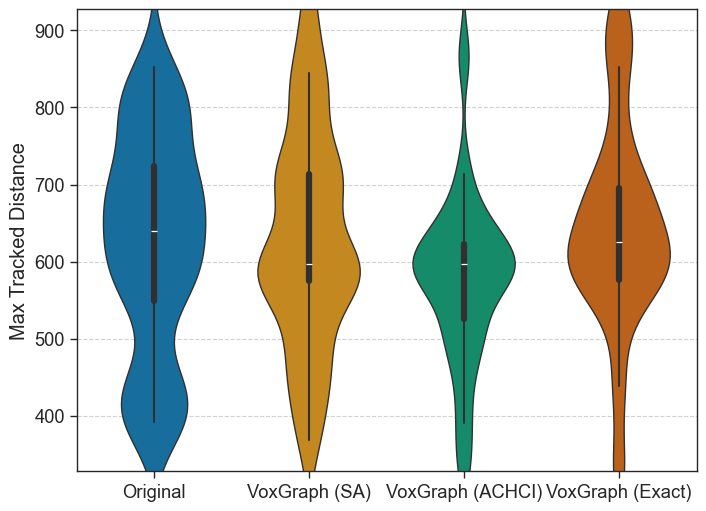

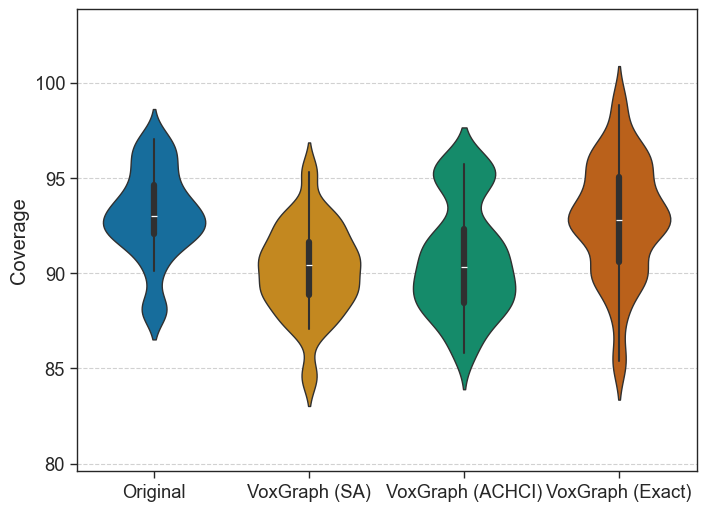

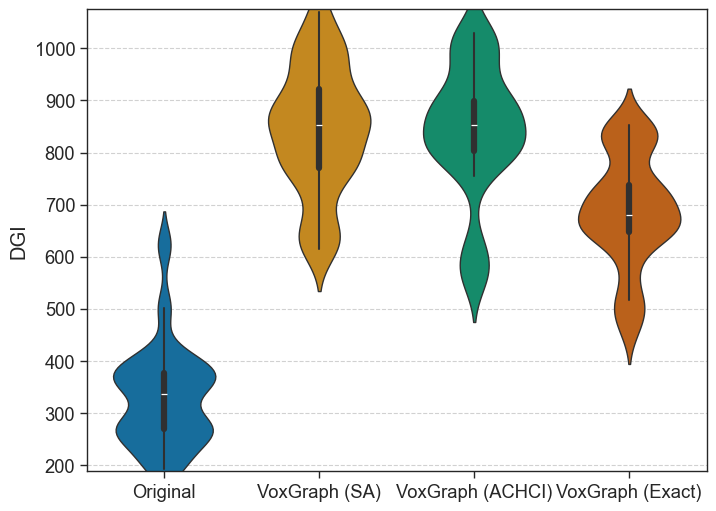

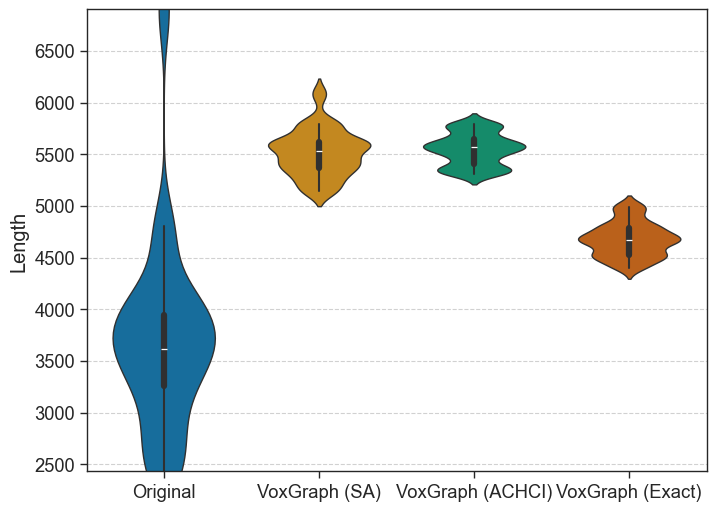

In [16]:
# Plot the violin plots with lines for the samples
for metric in metrics_combined.columns:
    plt.figure(figsize=(8, 6))
    sns.violinplot(
        data=metrics_combined[metric].reset_index(),
        x="method",
        y=metric,
        hue="method",
        # inner="quartile",
        width=0.66,
        bw_adjust=0.6,
        # inner_kws=dict(box_width=5, whis_width=2, color=".4"),
    )
    plt.ylim(
        metrics_combined[metric].min() - 5, metrics_combined[metric].max() + 5
    )  # Set y-axis limits
    plt.ylabel(metric.replace("_", " ").title().replace("Integrated Gradient", "DGI"))
    plt.xlabel("")  # Remove x-axis label
    plt.grid(True, linestyle="--", alpha=0.9, axis="y")
    plt.savefig(save_dir / f"{metric}_violin_plot.pdf", bbox_inches="tight")
    plt.show()

In [14]:
import wandb
import matplotlib.pyplot as plt
import pandas as pd

# Initialize the API
api = wandb.Api()
entity = "medsegmentor"
project = "toydata"
run_id = "zk15emqg"
run_ids = [
    "zk15emqg",
    "nfngi15t",  # + Revisit Penalty
    "8x8ev4ot",  # + Final Reward
    "207q9cu8",  # + Long Horizon (gamma=0.999)
]
run_ids = {
    "zk15emqg": "No Final Reward",
    # "nfngi15t": "+ Revisit Penalty",
    "8x8ev4ot": "+ Final Reward",
    "3vjt8ttk": "+ Mid-length Horizon (250 steps)",
    "207q9cu8": "+ Long Horizon (1000 steps)",
}

runs = [api.run(f"{entity}/{project}/{run_id}") for run_id in run_ids.keys()]
dfs = [run.history() for run in runs]
print(dfs[0].columns)


Index(['losses/value_loss', 'losses/entropy', '_timestamp', 'charts/action_1',
       'charts/max_gdt_achieved_max', '_step', 'losses/grad_norm',
       'train/episode_len', 'charts/action_0_mode', '_runtime', 'losses/beta',
       'charts/action_1_std', 'charts/learning_rate', 'charts/action_2_std',
       'charts/action_2_mode', 'charts/action_0_std', 'train/max_reward',
       'charts/max_gdt_achieved_std', 'losses/alpha', 'charts/num_updates',
       'train/final_coverage', 'train/step_count', 'losses/policy_loss',
       'charts/max_gdt_achieved', 'train/wall_gradient',
       'charts/action_1_mode', 'charts/action_0', 'train/reward',
       'train/total_reward', 'losses/kl_div', 'charts/action_2'],
      dtype='object')


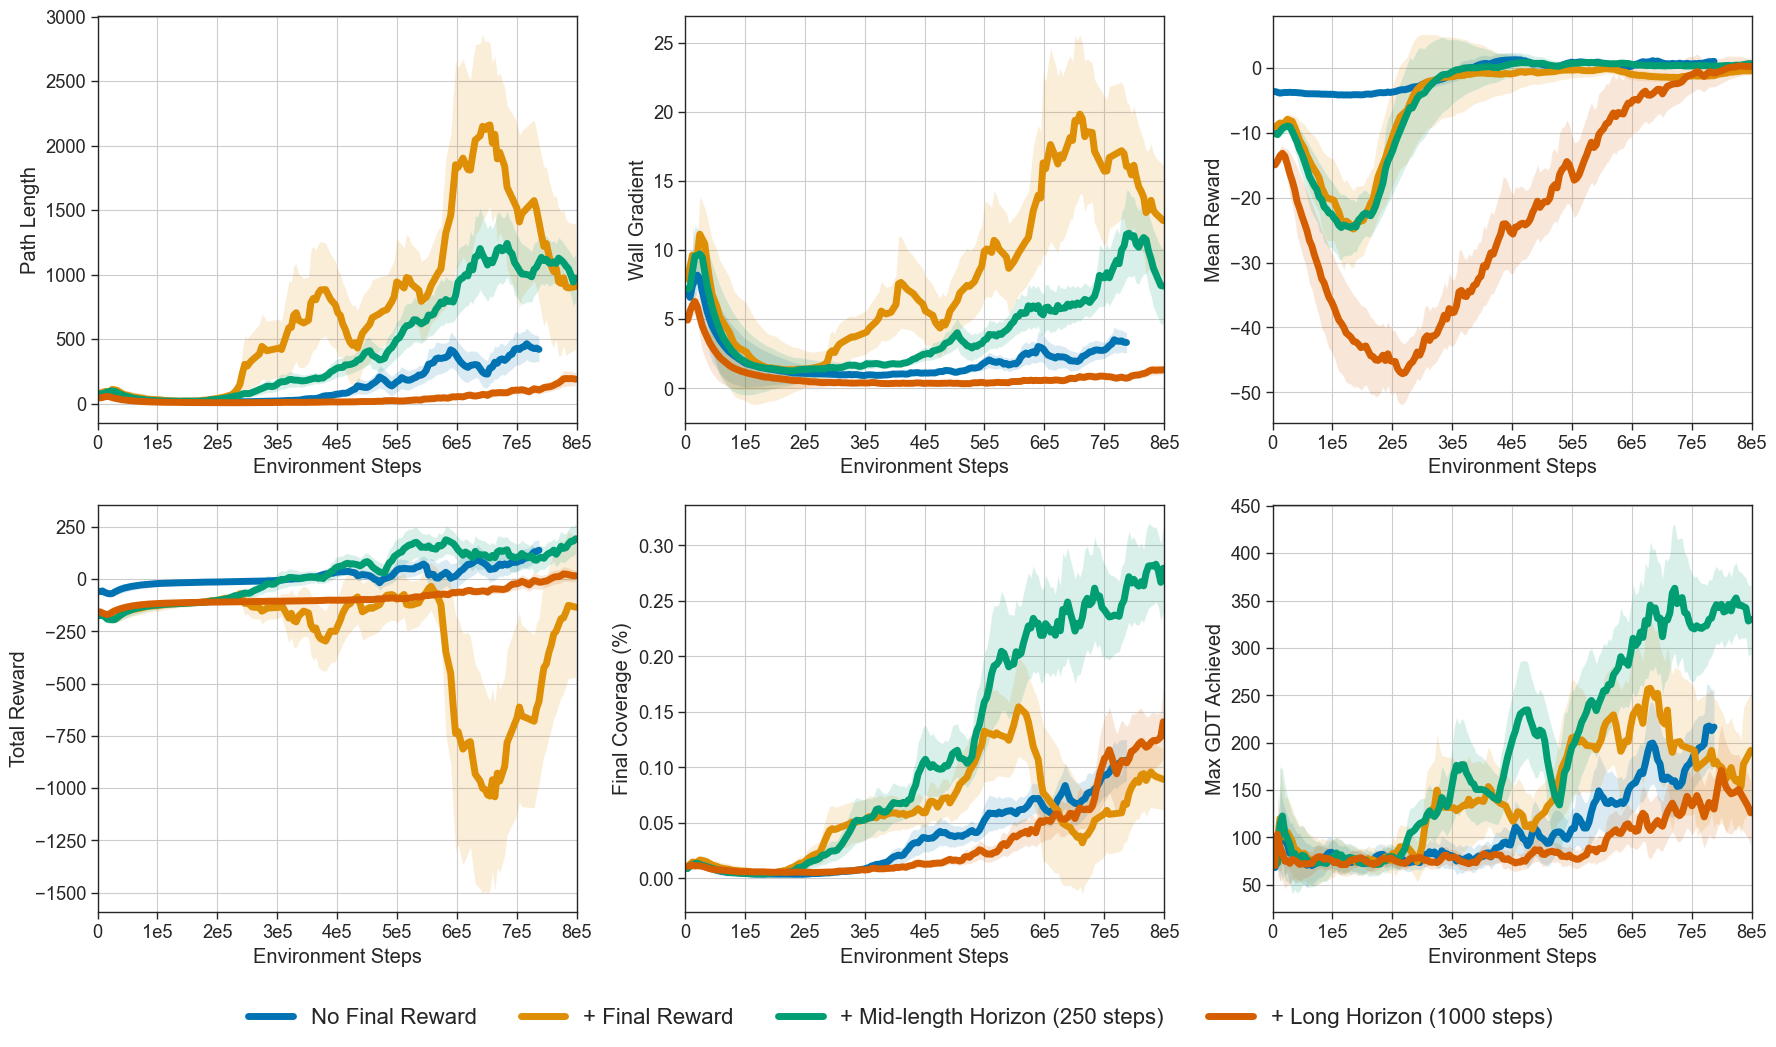

In [37]:
from matplotlib.ticker import FuncFormatter


def format_func(value, tick_number):
    """
    Custom formatter to display ticks in scientific notation.
    """
    if value == 0:
        return "0"
    s = f"{value:.1e}"  # Format as scientific notation
    mantissa, exponent = s.split("e")
    if exponent.startswith("+"):
        exponent = exponent[1:]
    if exponent.startswith("0"):
        exponent = exponent[1:]
    mantissa = mantissa.rstrip("0").rstrip(".")  # Remove trailing zeros and decimal point
    return f"{mantissa}e{exponent}"


# The desired columns are:
# "train/episode_len" -> "Path Length"
# "train/wall_gradient" -> "Wall Gradient"
# train/reward -> "Mean Reward"
# train/total_reward -> "Total Reward"
# charts/max_gdt_achieved -> "Max GDT Achieved"
columns = [
    "train/episode_len",
    "train/wall_gradient",
    "train/reward",
    "train/total_reward",
    "train/final_coverage",
    "charts/max_gdt_achieved",
]
columns_renamed = [
    "Path Length",
    "Wall Gradient",
    "Mean Reward",
    "Total Reward",
    "Final Coverage (%)",
    "Max GDT Achieved",
]
rename_col = {col: new_col for col, new_col in zip(columns, columns_renamed)}
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
handles = []
max_steps = 800_000  # Limit to the first 500,000 steps
# xrange = idx
for ax, col in zip(axs.flatten(), columns):
    for run, label in zip(dfs, run_ids.values()):
        idx = run["_step"]
        xrange = idx < max_steps  # Limit to the first 500,000
        _idx = idx[xrange]
        data = run[col][xrange]
        # print(len(_idx), len(data), col)
        data_smooth = data.ewm(span=10, adjust=True).mean()
        (line,) = ax.plot(_idx, data_smooth, label=label, linewidth=5)
        handles.append(line)
        # Plot the STD as a shaded area
        std = data.ewm(span=20, adjust=True).std()
        ax.fill_between(
            _idx,
            data_smooth - std,
            data_smooth + std,
            alpha=0.15,
        )
        ax.set_xlabel("Environment Steps")
        ax.set_ylabel(rename_col[col])
        ax.set(xlim=(0, max_steps))
        ax.xaxis.set_major_formatter(FuncFormatter(format_func))
        ax.grid(True)

fig.legend(
    handles=handles[: len(run_ids)],
    ncol=len(run_ids),
    bbox_to_anchor=(0.88, 0),
    bbox_transform=fig.transFigure,
    frameon=False,
    fontsize=16,
)

fig.tight_layout()
fig.savefig(save_dir / "ppo_training_metrics.pdf", bbox_inches="tight")


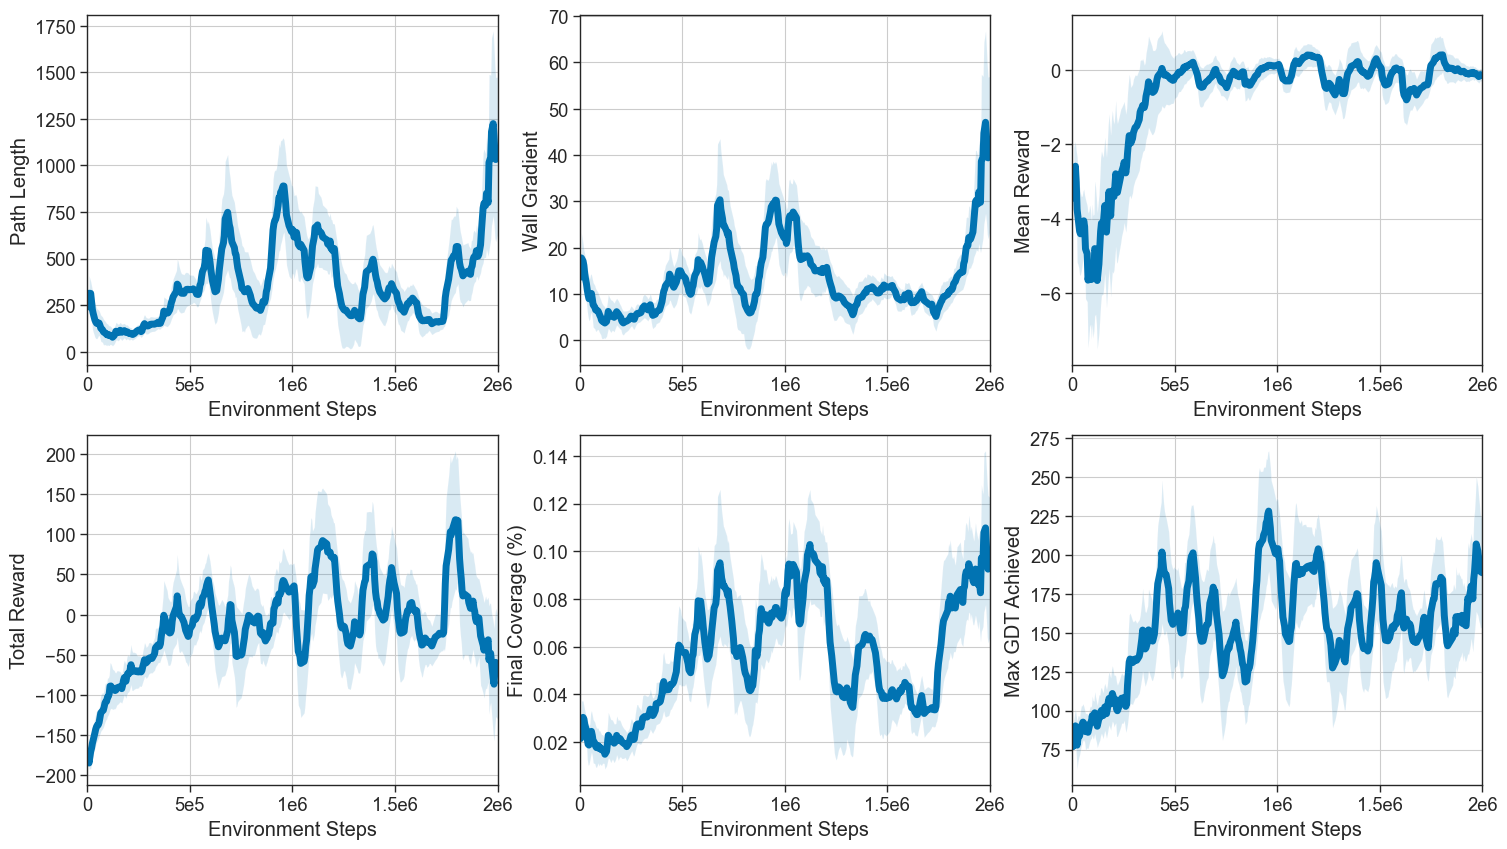

In [39]:
run = "66a3g4eh"
run = api.run(f"{entity}/{project}/{run}")

# Get the history of the run
history = run.history()
# Convert to a DataFrame
df = pd.DataFrame(history)

# Visualize the training metrics
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
handles = []
max_steps = 2_000_000  # Limit to the first 500,000 steps
# xrange = idx
for ax, col in zip(axs.flatten(), columns):
    idx = df["_step"]
    xrange = idx < max_steps  # Limit to the first 500,000
    _idx = idx[xrange]
    data = df[col][xrange]
    # print(len(_idx), len(data), col)
    data_smooth = data.ewm(span=10, adjust=True).mean()
    (line,) = ax.plot(_idx, data_smooth, linewidth=5)
    handles.append(line)
    # Plot the STD as a shaded area
    std = data.ewm(span=20, adjust=True).std()
    ax.fill_between(
        _idx,
        data_smooth - std,
        data_smooth + std,
        alpha=0.15,
    )
    ax.set_xlabel("Environment Steps")
    ax.set_ylabel(rename_col[col])
    ax.set(xlim=(0, max_steps))
    ax.xaxis.set_major_formatter(FuncFormatter(format_func))
    ax.grid(True)

fig.savefig(save_dir / f"ppo_training_metrics_{run_id}.pdf", bbox_inches="tight")